In [5]:
# --------------------
# Package import

import numpy as np
import pickle
import matplotlib.pyplot as plt
import scipy.special as special
import scipy.interpolate as interpolate
import seaborn as sns

colors = sns.color_palette('bright')

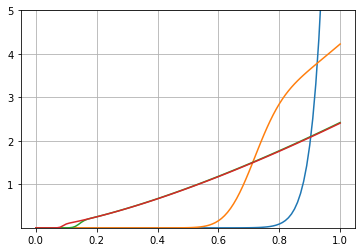

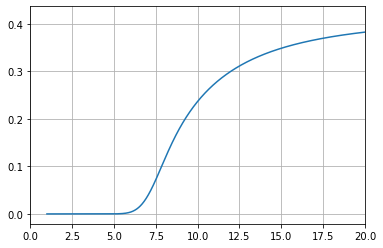

In [62]:
#### Mass parameters

mmin = 4.59
delta = 4.82
beta = 1.40
lambda_p = 0.10

def secondary_mass(Mc, m1):

    A = (1. - 4.*Mc**5 / 27./ m1**5)**(1./2.)
    S = Mc**5/2./m1**2 * (1.-A)
    T = Mc**5/2./m1**2 * (1.+A)

    return S**(1./3.) + T**(1./3.)

def dm2dMc (Mc, m1):

    A = (1. - 4.*Mc**5 / 27./ m1**5)**(1./2.)
    S = Mc**5/2./m1**2 * (1.+A)
    T = Mc**5/2./m1**2 * (1.-A)
    dSdMc = (5./Mc * S - 5.*Mc**9./27./m1**7/A)
    dTdMc = (5./Mc * T + 5.*Mc**9./27./m1**7/A)
    return 1./3. * S**(-2./3.) * dSdMc + 1./3. * T**(-2./3.) * dTdMc



#### Smoothing function

def smoothing(mm, mmin, delta):
    tmp = (1. + special.erf(mm-(mmin+delta/2.))) / 2.
    return tmp


#### Secondary mass distribution

def norm_secondary(m1):

    q = np.linspace(0.,1.,1001)
    step = np.diff(q)[:,np.newaxis]
    qq = np.tile(q,(m1.shape[0],1)).transpose()
    mm1 = np.tile(m1, (q.shape[0],1))

    SSP = qq**beta * smoothing(mm=qq*mm1, mmin=mmin, delta=delta)
    P = np.sum( (SSP[1:]+SSP[:-1]) * step/2. , axis=0)

    return P

mass1 = np.linspace(1.,101.,1001)
norm_secondary_pdf = interpolate.interp1d(mass1, norm_secondary(mass1), kind='cubic')

def secondary_pdf(q,m1):
    tmp = q**beta * smoothing(mm=q*m1, mmin=mmin, delta=delta) / norm_secondary_pdf(m1)
    return tmp


#### Primary mass distribution

def smoothed_gaussian(x):
    mu = 33.07
    sigma = 5.69
    return np.exp(-(x-mu)**2./2./sigma**2) * smoothing(mm=x, mmin=4.59, delta=4.82)

def smoothed_powerlaw(x):
    alpha = -2.63
    mmax = 86.22
    y = x**alpha * smoothing(mm=x, mmin=4.59, delta=4.82)
    y[x>mmax] = 0.
    return y

masses = np.linspace(1.,100., 10001)

GG = smoothed_gaussian(masses)
NSG = np.sum((GG[:-1]+GG[1:])*np.diff(masses)/2.)

PP = smoothed_powerlaw(masses)
NSP = np.sum((PP[:-1]+PP[1:])*np.diff(masses)/2.)

def primary_pdf(mm):

    G = smoothed_gaussian(mm) / NSG
    P = smoothed_powerlaw(mm) / NSP

    return (1-lambda_p) * P + lambda_p * G


m1 = [5., 10., 50., 80.]
q = np.linspace(0., 1., 101)

for mm1 in m1:
    plt.plot(q, secondary_pdf(q,mm1))
plt.ylim(1.e-3, 5.)
plt.grid()
plt.show()

plt.plot(masses, norm_secondary_pdf(masses))
#plt.yscale('log')
plt.xlim(0., 20.)
plt.grid()
plt.show()



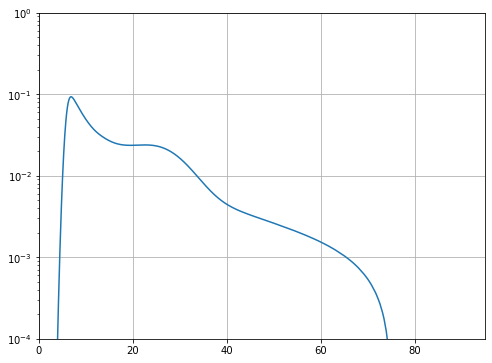

In [59]:

#### Chirp mass PDF

def chirpmass_pdf(Mc):
    
    mm1 = np.linspace(2.**(1./5.)*Mc + 0.01, 100., 1001)
    MM = np.tile(Mc, (mm1.shape[0],1))
    mm2 = secondary_mass(MM, mm1)
    qq = mm2/mm1

    primary = primary_pdf(mm1)
    secondary = secondary_pdf(qq, mm1)
    JJ = dm2dMc(MM, mm1)

    yy = primary * secondary * JJ
    y = np.sum( (yy[1:]+yy[:-1]) * np.diff(mm1, axis=0)/2. , axis=0)
    return y

chirps = np.linspace(1.,80.,1001)
chirps_pdf = chirpmass_pdf(chirps)
norm_chirpmass_pdf = np.sum((chirps_pdf[:-1]+chirps_pdf[1:]) * np.diff(chirps)/2.)

plt.figure(figsize=(8.,6.))
plt.plot(chirps, chirpmass_pdf(chirps)/norm_chirpmass_pdf)
plt.yscale('log')
plt.ylim(1.e-4, 1.)
plt.xlim(0., 95.)
plt.grid()
plt.show()